Kobe Bryant marked his retirement from the NBA by scoring 60 points in his final game as a Los Angeles Laker on Wednesday, April 12, 2016. Drafted into the NBA at the age of 17, Kobe earned the sport’s highest accolades throughout his long career.

Using 20 years of data on Kobe's swishes and misses, can you predict which shots will find the bottom of the net? This competition is well suited for practicing classification basics, feature engineering, and time series analysis.

In [382]:
# %%capture
# pip install missingno

In [383]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import math
import missingno as ms

In [384]:
plt.rcParams['figure.figsize'] = (14,5)
plt.rcParams["font.family"] = "monospace"
plt.rcParams['axes.edgecolor'] = 'black'

plt.rcParams['figure.frameon'] = True
plt.rcParams['axes.linewidth'] = 1.5

import warnings
warnings.filterwarnings("ignore")

In [385]:
df = pd.read_csv('train.csv', parse_dates=['game_date'])
df.head()

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,...,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,...,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,...,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,...,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,...,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,...,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


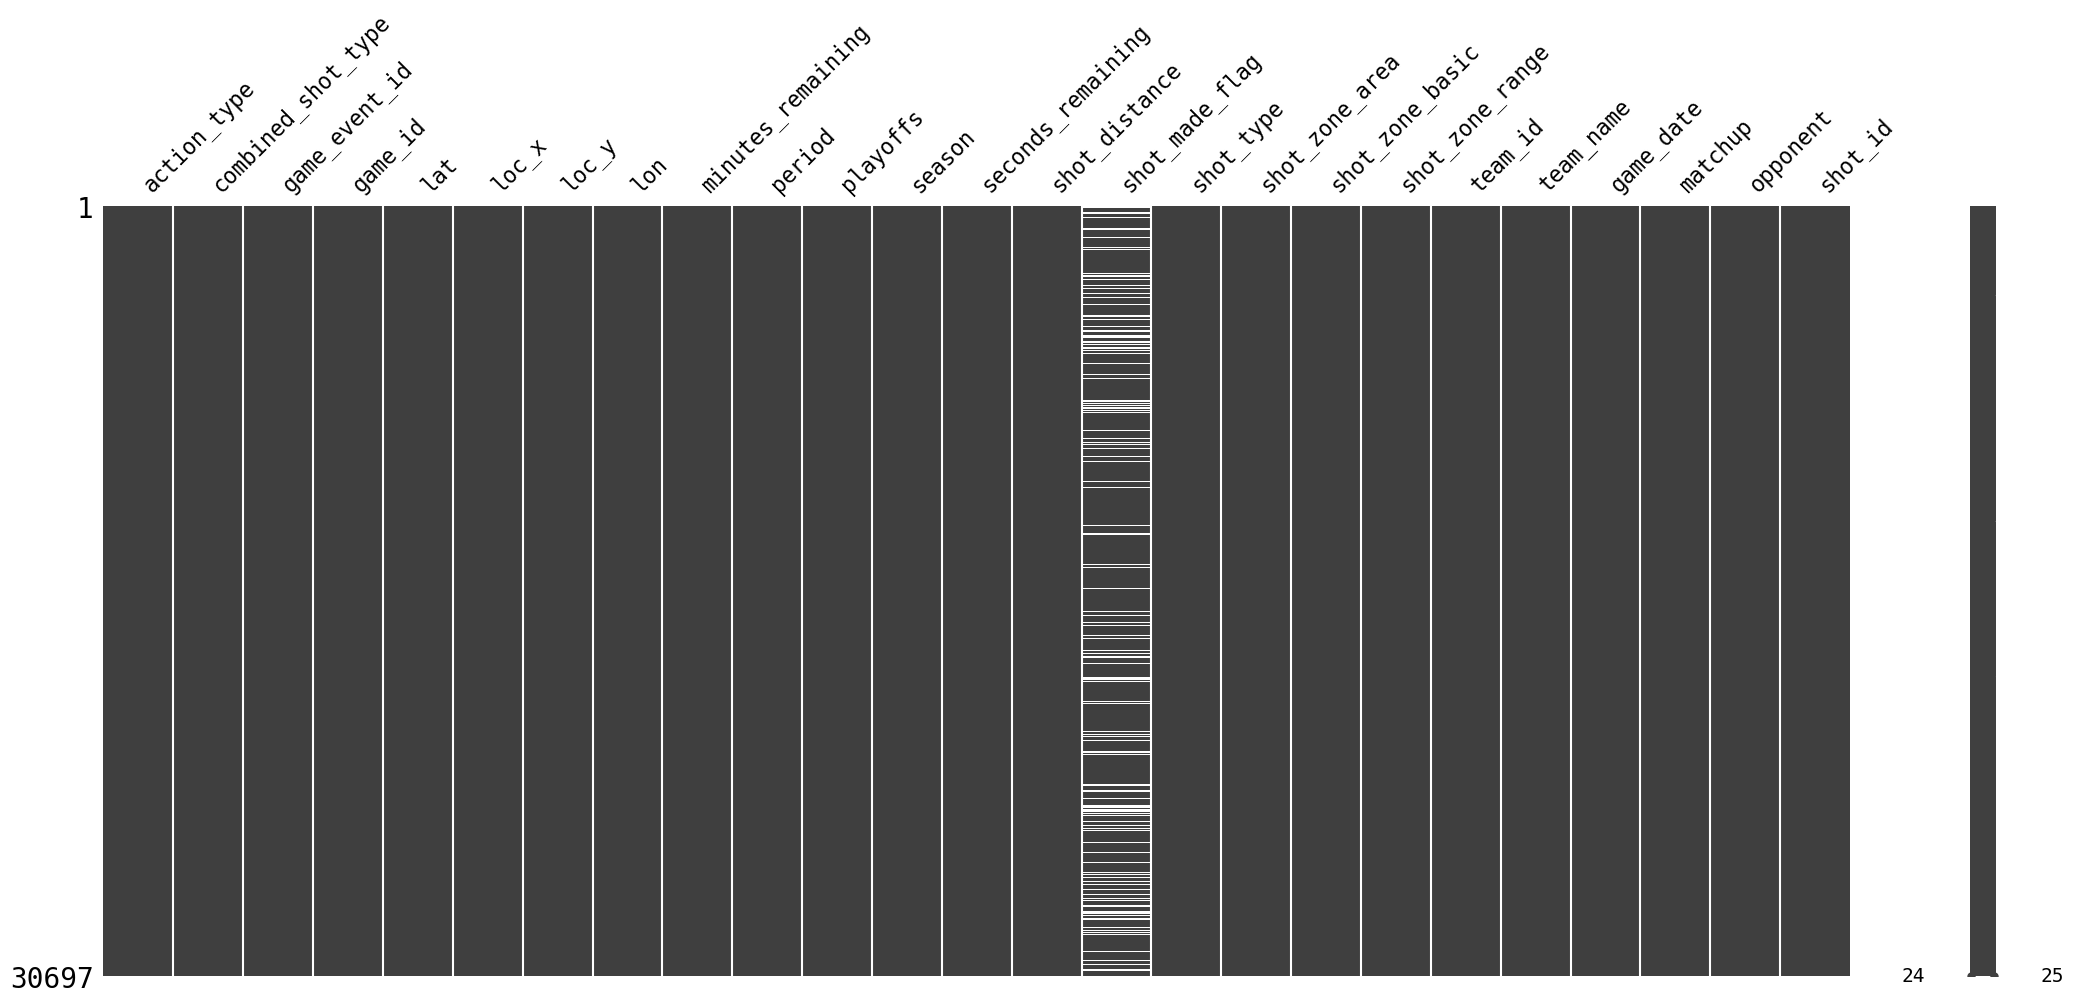

In [386]:
ms.matrix(df);

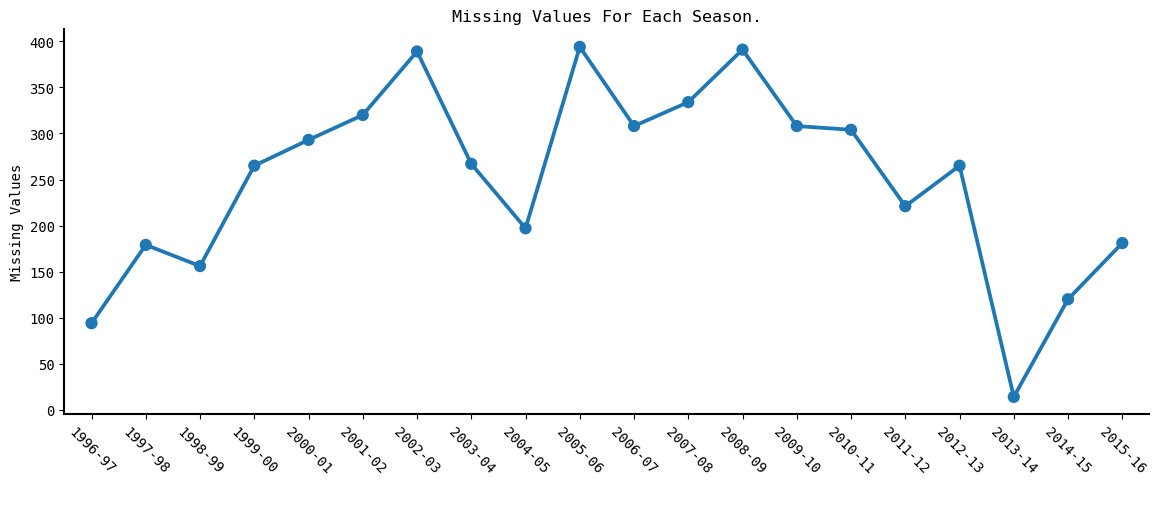

In [387]:
nans = df.groupby("season")[["shot_made_flag"]].value_counts(dropna=False).unstack()[[np.nan]].reset_index()
sns.pointplot(x='season', y=np.nan, data=nans)
plt.xticks(rotation=-45)
plt.title("Missing Values For Each Season.")
plt.ylabel("Missing Values")
plt.xlabel(" ")
sns.despine()

In [388]:
train = df.drop(columns=['game_id', 'game_event_id','team_id', 'shot_id', 'team_name'])

In [389]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30697 entries, 0 to 30696
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   action_type         30697 non-null  object        
 1   combined_shot_type  30697 non-null  object        
 2   lat                 30697 non-null  float64       
 3   loc_x               30697 non-null  int64         
 4   loc_y               30697 non-null  int64         
 5   lon                 30697 non-null  float64       
 6   minutes_remaining   30697 non-null  int64         
 7   period              30697 non-null  int64         
 8   playoffs            30697 non-null  int64         
 9   season              30697 non-null  object        
 10  seconds_remaining   30697 non-null  int64         
 11  shot_distance       30697 non-null  int64         
 12  shot_made_flag      25697 non-null  float64       
 13  shot_type           30697 non-null  object    

In [390]:
dtypes = {'minutes_remaining': np.uint8,
            'playoffs': np.bool_,
            'shot_made_flag': np.bool_,
            'shot_distance': np.uint8,
            'period': np.uint8,
            'seconds_remaining':np.uint8}

In [391]:
train = train.astype(dtypes, copy=False)

In [392]:
columns = ['action_type',
         'combined_shot_type',
         'shot_type',
         'shot_zone_area',
         'shot_zone_basic',
         'shot_zone_range']

In [393]:
for i in columns:
    print(train[i].value_counts())
    print("=="*40)
    print("\n")

Jump Shot                             18880
Layup Shot                             2567
Driving Layup Shot                     1978
Turnaround Jump Shot                   1057
Fadeaway Jump Shot                     1048
Running Jump Shot                       926
Pullup Jump shot                        476
Turnaround Fadeaway shot                439
Slam Dunk Shot                          411
Reverse Layup Shot                      395
Jump Bank Shot                          333
Driving Dunk Shot                       310
Dunk Shot                               262
Tip Shot                                182
Alley Oop Dunk Shot                     122
Step Back Jump shot                     118
Floating Jump shot                      114
Driving Reverse Layup Shot               97
Hook Shot                                84
Driving Finger Roll Shot                 82
Alley Oop Layup shot                     80
Reverse Dunk Shot                        75
Running Layup Shot              

In [394]:
train.shot_type.replace(['2PT Field Goal', '3PT Field Goal'], [0,1], inplace=True)
train.shot_type.value_counts()

0    24271
1     6426
Name: shot_type, dtype: int64

In [395]:
train.describe()

,lat,loc_x,loc_y,lon,minutes_remaining,period,seconds_remaining,shot_distance,shot_type
count,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000
mean,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,28.365085,13.437437,0.209336
std,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,17.478949,9.374189,0.406842
min,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000
25%,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,13.000000,5.000000,0.000000
50%,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,28.000000,15.000000,0.000000
75%,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,43.000000,21.000000,0.000000
max,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,59.000000,79.000000,1.000000


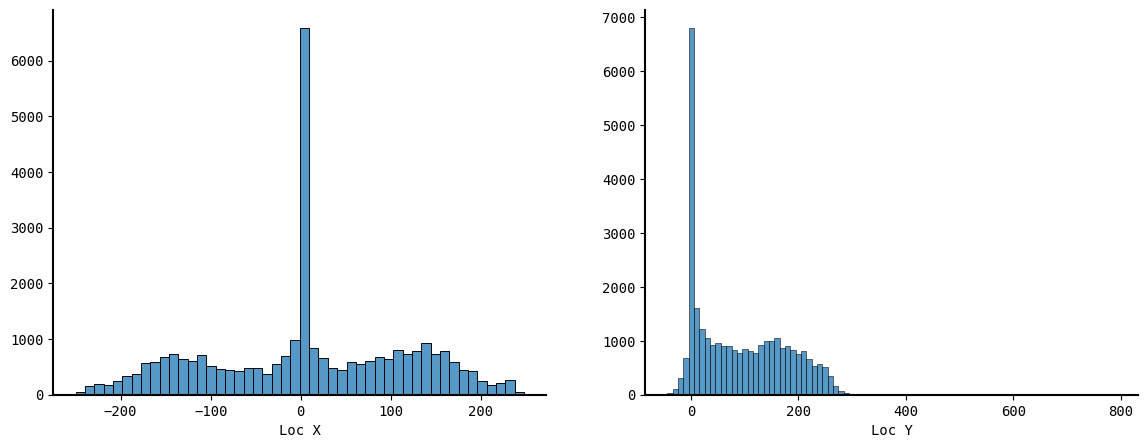

In [396]:
fig, axs = plt.subplots(ncols=2)

sns.histplot(x='loc_x', data=train, ax=axs[0])
axs[0].set_ylabel("")
sns.despine()
axs[0].set_xlabel("Loc X")

sns.histplot(x='loc_y', data=train, ax=axs[1])
plt.ylabel("")
sns.despine()
plt.xlabel('Loc Y');

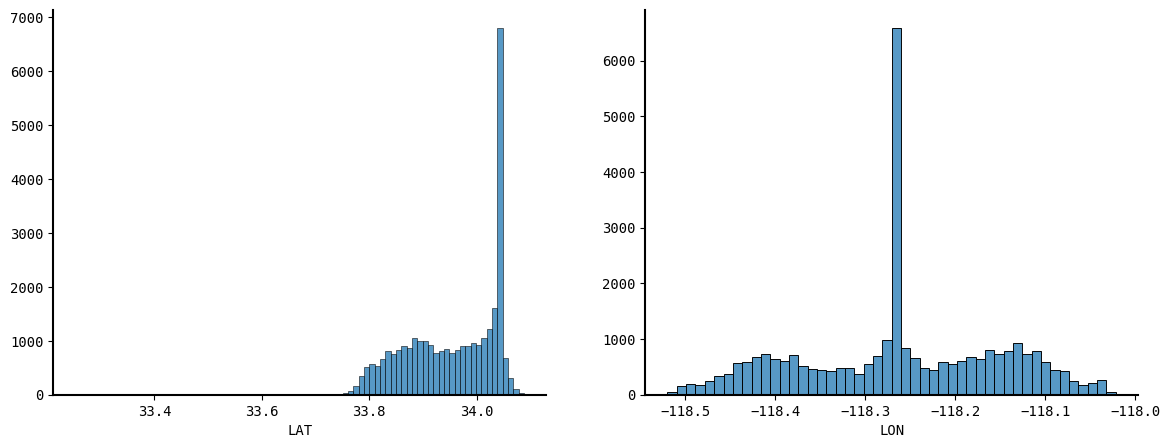

In [397]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(x='lat', data=train, ax=axs[0])
axs[0].set_ylabel("")
sns.despine()
axs[0].set_xlabel("LAT")

sns.histplot(x='lon', data=train, ax=axs[1])
plt.ylabel("")
sns.despine()
plt.xlabel('LON');

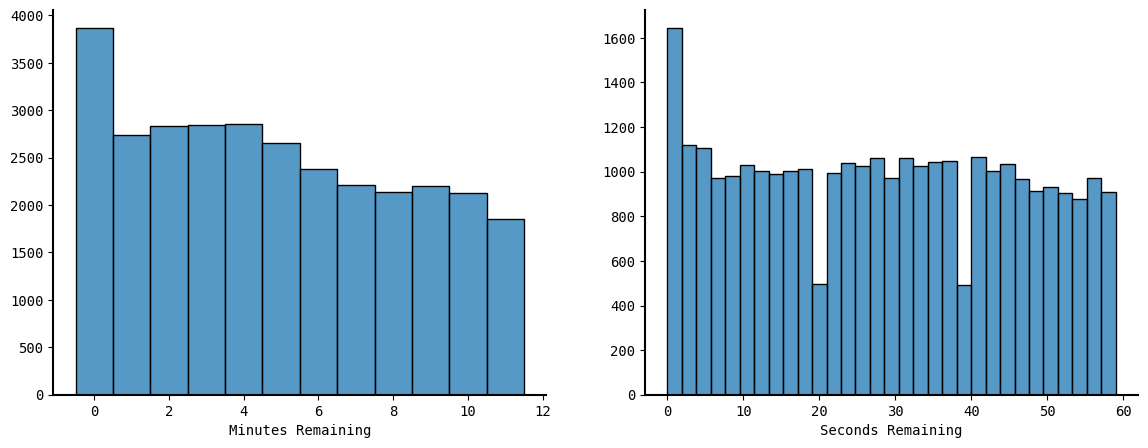

In [398]:
fig, axs = plt.subplots(ncols=2)
sns.histplot(x='minutes_remaining', data=train, ax=axs[0], discrete=True)
axs[0].set_ylabel("")
sns.despine()
axs[0].set_xlabel("Minutes Remaining")

sns.histplot(x='seconds_remaining', data=train, ax=axs[1])
plt.ylabel("")
sns.despine()
plt.xlabel('Seconds Remaining');

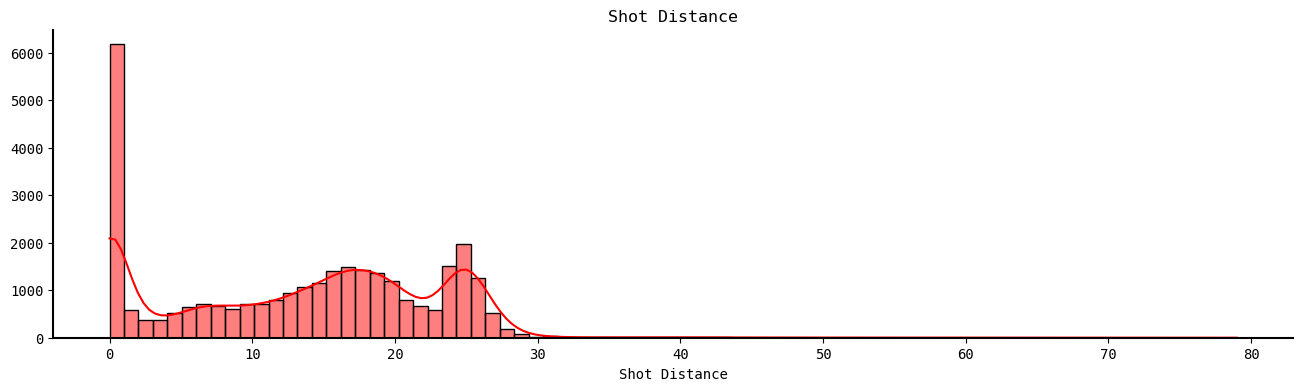

In [399]:
plt.figure(figsize=(16,4))
sns.histplot(x='shot_distance',
             data=train,
             kde=True,
             color='red')

plt.title("Shot Distance")
plt.ylabel('')
sns.despine()
plt.xlabel('Shot Distance');

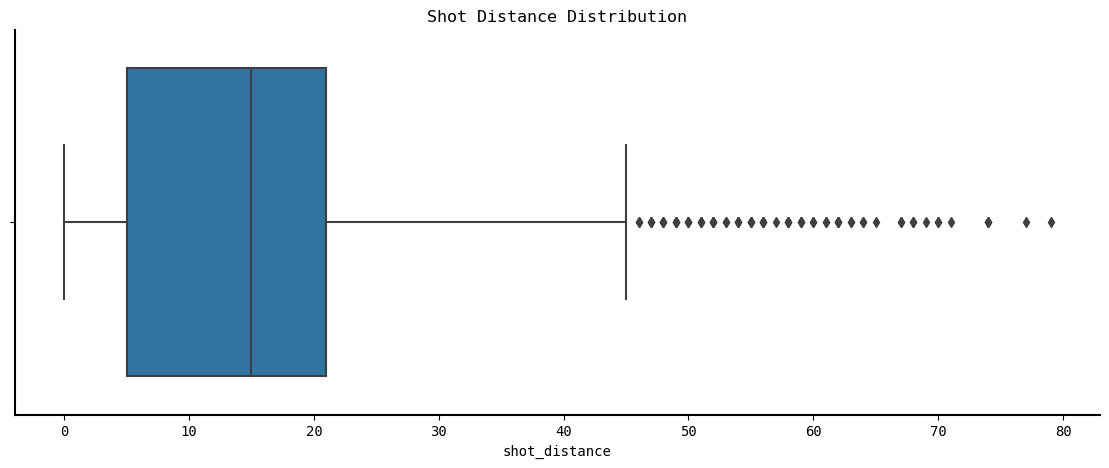

In [400]:
sns.boxplot(x='shot_distance', data=train)
plt.title("Shot Distance Distribution")
sns.despine()

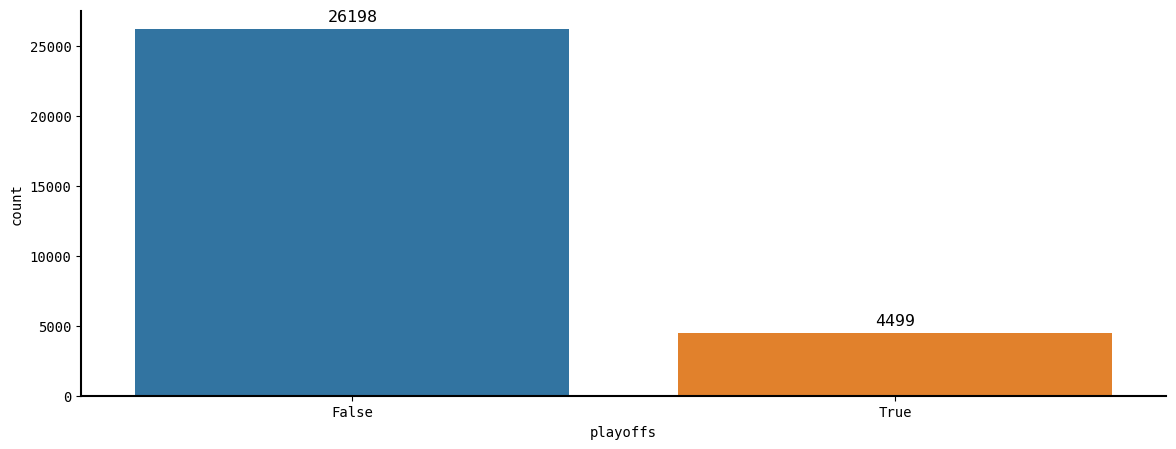

In [401]:
ax=sns.countplot(x='playoffs', data=train)
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
sns.despine()

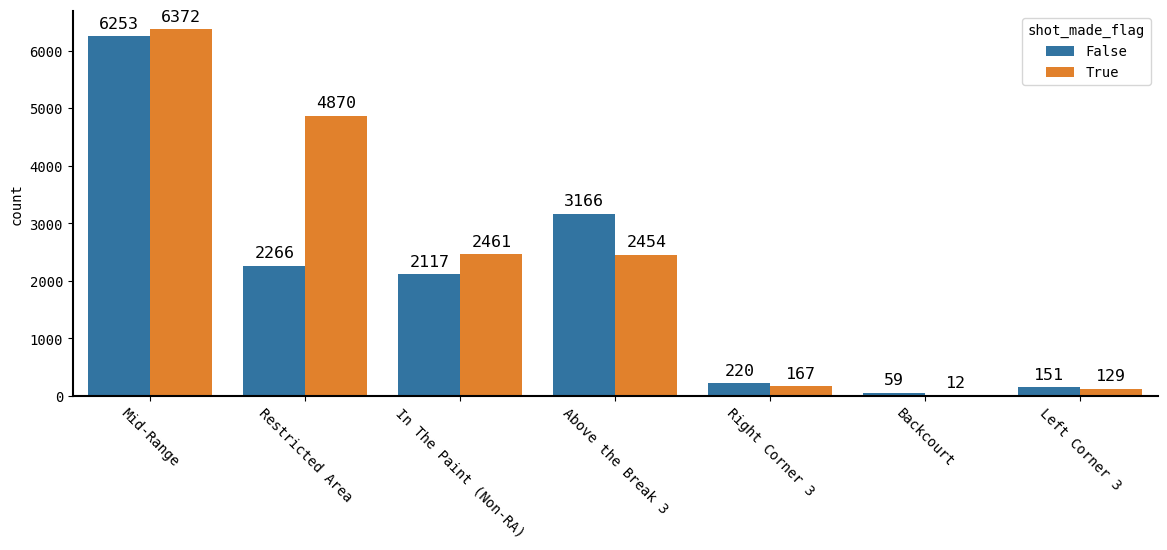

In [402]:
ax = sns.countplot(x='shot_zone_basic', data=train, hue='shot_made_flag')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xticks(rotation=-45)
plt.xlabel("")
sns.despine()

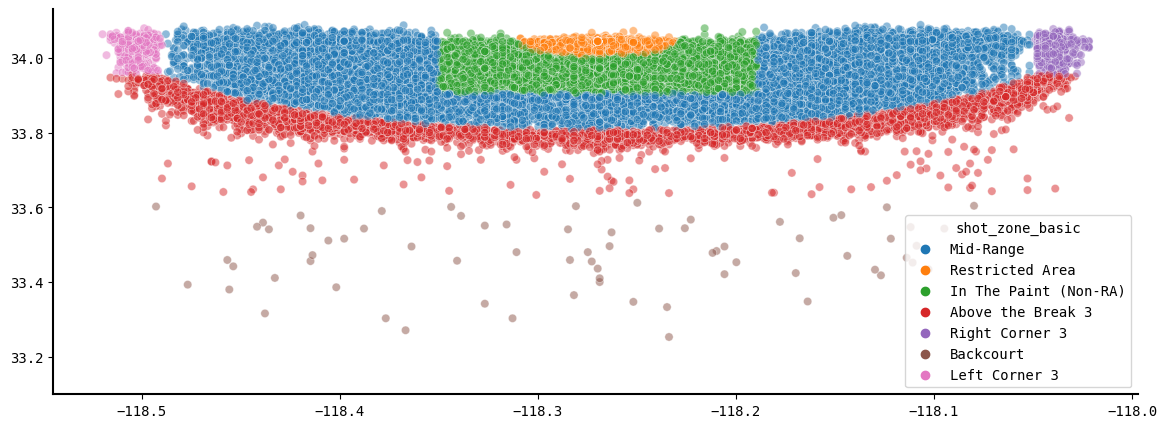

In [403]:
sns.scatterplot(x='lon', y='lat', data=train, alpha=0.5, hue='shot_zone_basic');
plt.xlabel("")
plt.ylabel("")
plt.ylim(bottom=33.1)
sns.despine()

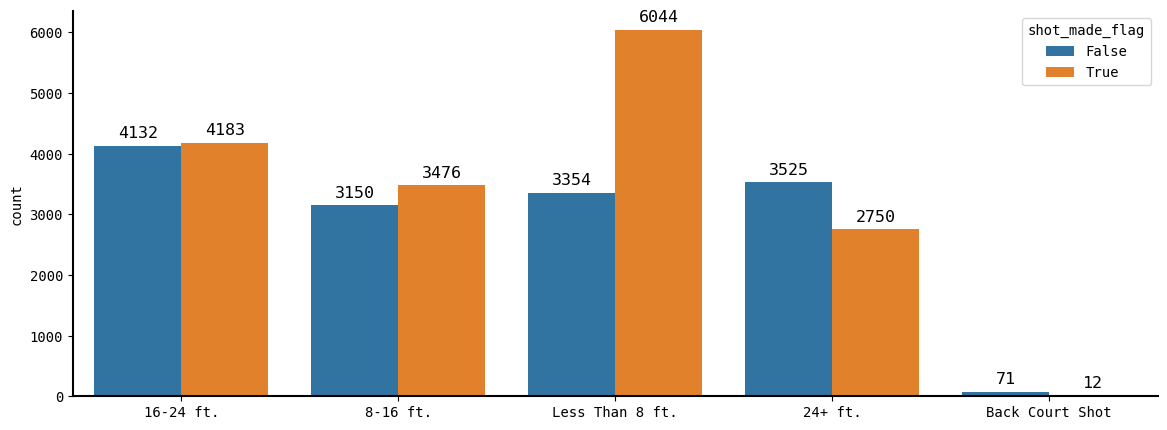

In [404]:
plt.xlabel("")
sns.despine()
ax = sns.countplot(x='shot_zone_range', data=train, hue='shot_made_flag')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
#plt.xticks(rotation=-45)
plt.xlabel("")
sns.despine()

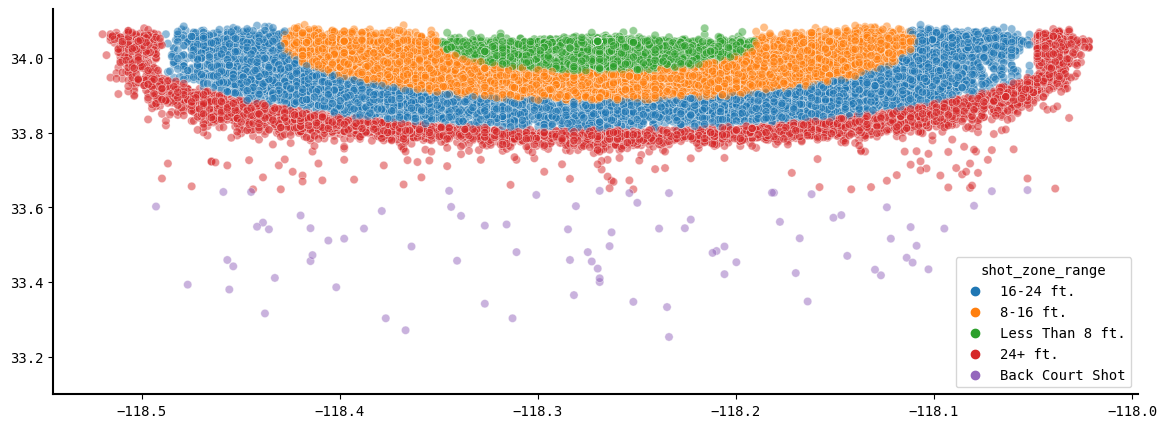

In [405]:
sns.scatterplot(x='lon', y='lat', data=train, alpha=0.5, hue='shot_zone_range');
plt.xlabel("")
plt.ylabel("")
plt.ylim(bottom=33.1)
sns.despine()

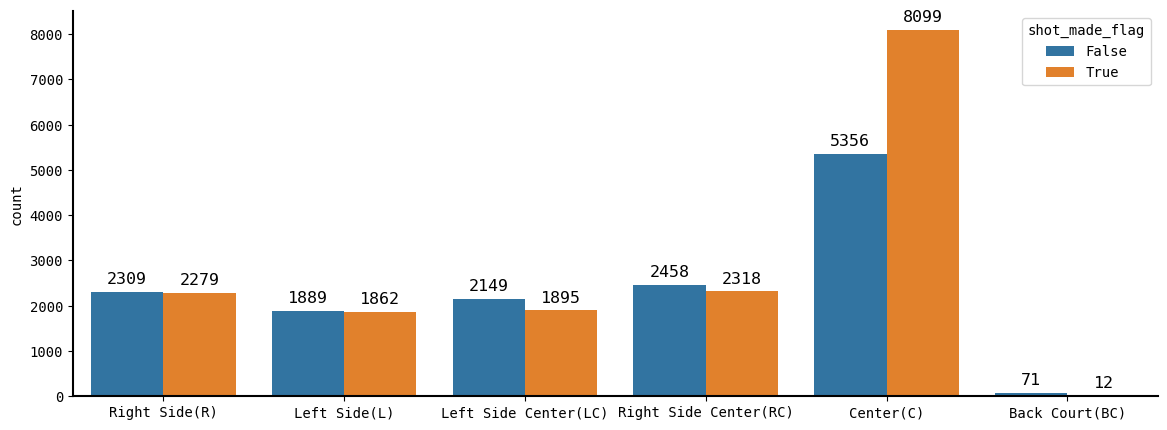

In [406]:
ax = sns.countplot(x='shot_zone_area', data=train, hue='shot_made_flag')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
#plt.xticks(rotation=-45)
plt.xlabel("")
sns.despine()

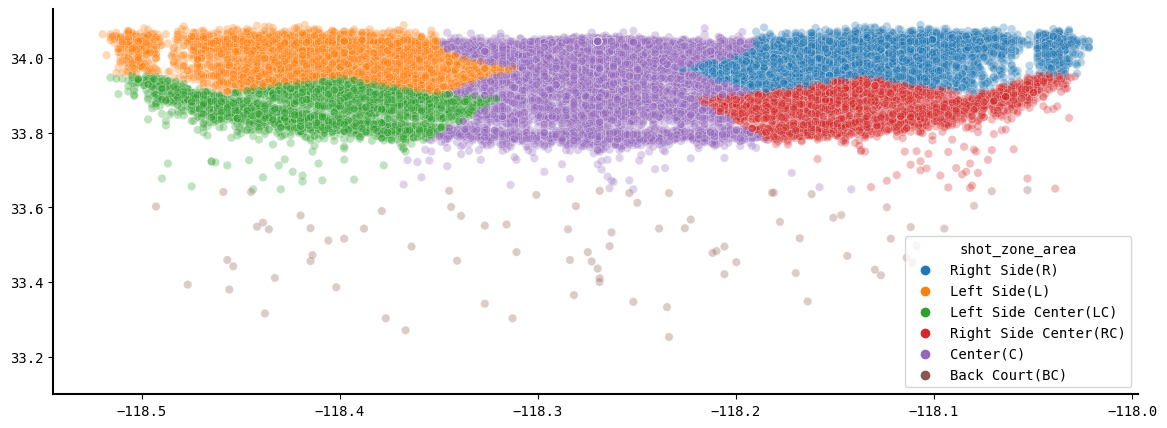

In [407]:
sns.scatterplot(x='lon', y='lat', data=train, alpha=0.3, hue='shot_zone_area')
plt.xlabel("")
plt.ylabel("")
plt.ylim(bottom=33.1)
sns.despine()

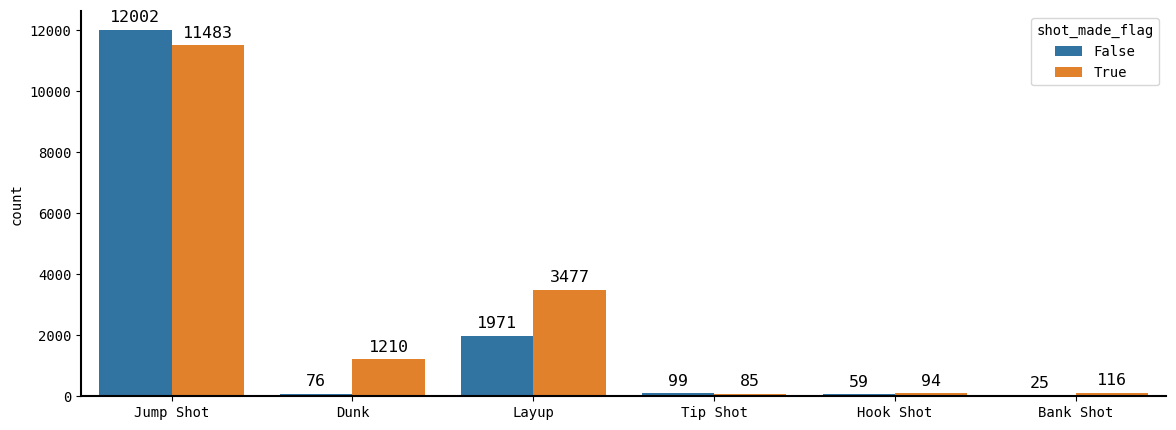

In [408]:
ax = sns.countplot(x='combined_shot_type', data=train, hue='shot_made_flag')
for p in ax.patches:
    ax.annotate(format(p.get_height()), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   size=12,
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.xlabel("")
sns.despine()

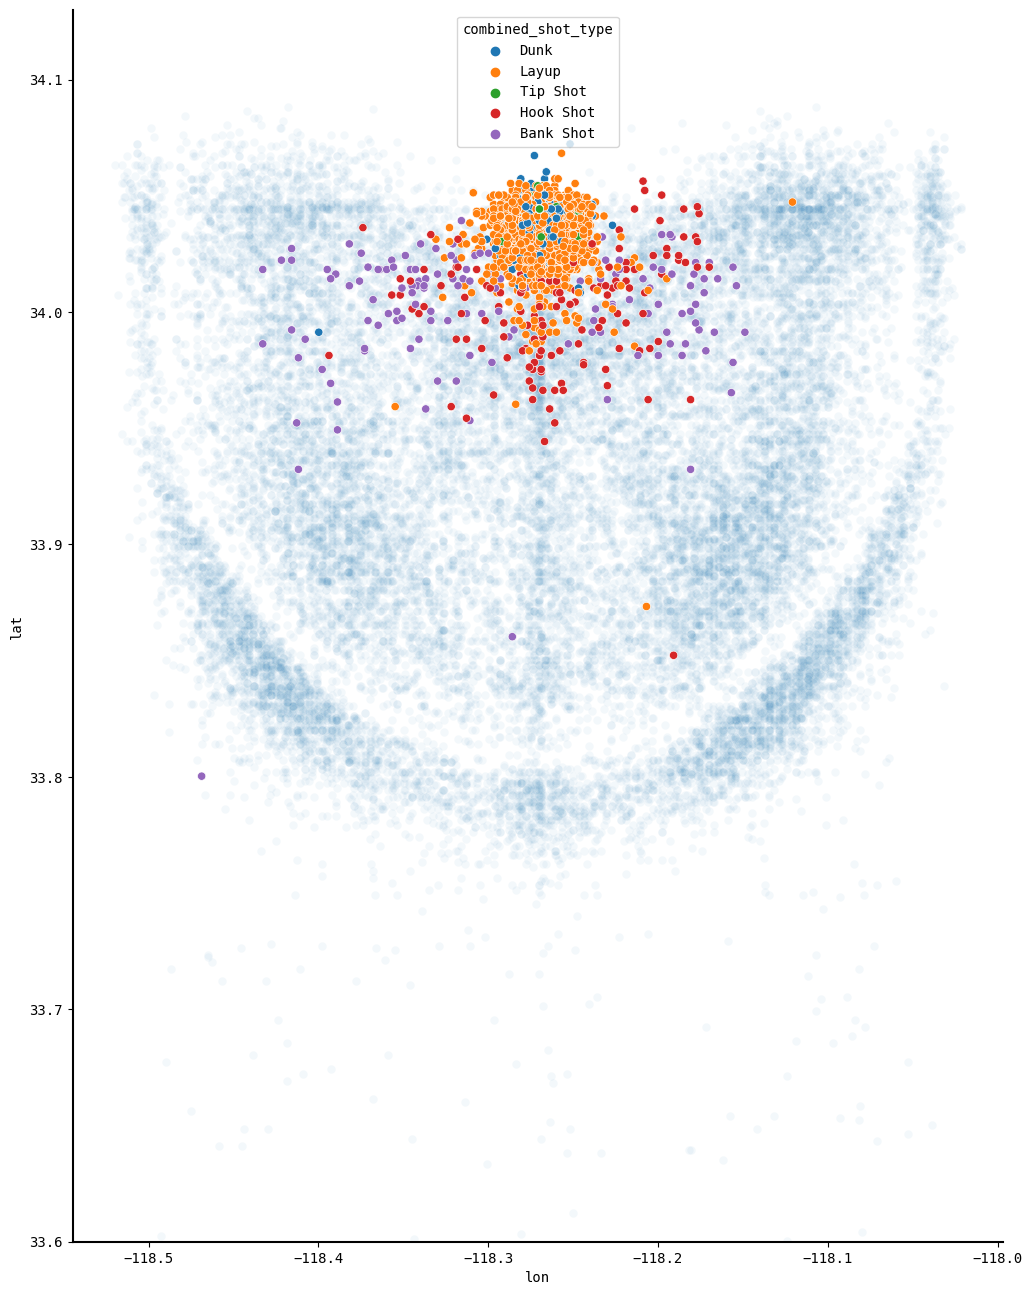

In [409]:
plt.figure(figsize=(12,16))

train["alpha"] = np.where(train.combined_shot_type == "Jump Shot", .05, 1)

ax = sns.scatterplot(x='lon', y='lat', data=train[train.alpha == 0.05], alpha=0.05)
sns.scatterplot(x='lon', y='lat', data=train[train.alpha == 1], hue='combined_shot_type', alpha=1, ax=ax)

plt.ylim(bottom=33.6)
sns.despine()

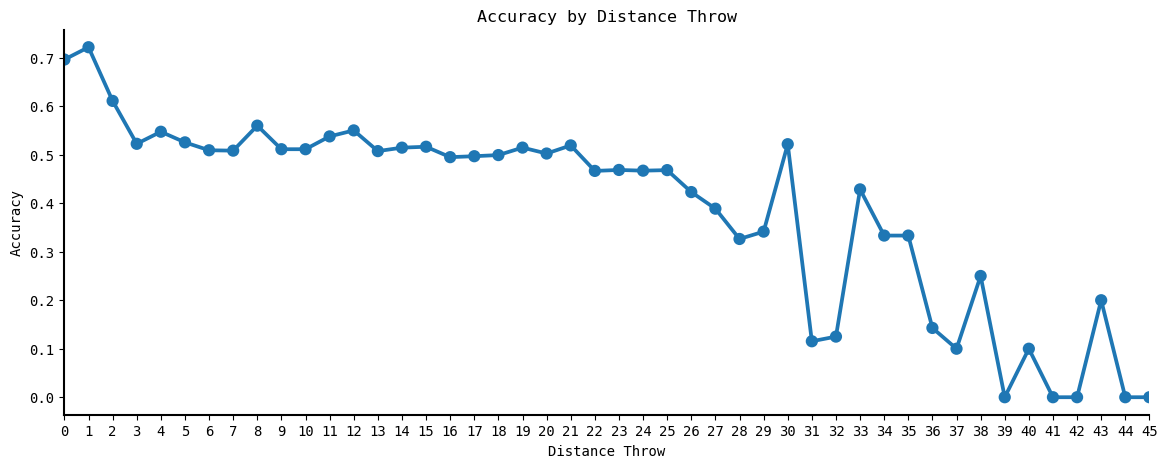

In [410]:
d = train.groupby("shot_distance")[['shot_made_flag']].mean().sort_values(by='shot_made_flag',ascending=False).reset_index()

sns.pointplot(x='shot_distance', y='shot_made_flag', data=d)
plt.title('Accuracy by Distance Throw')
plt.ylabel('Accuracy')
plt.xlabel('Distance Throw')
plt.xlim(0, 45)
sns.despine()

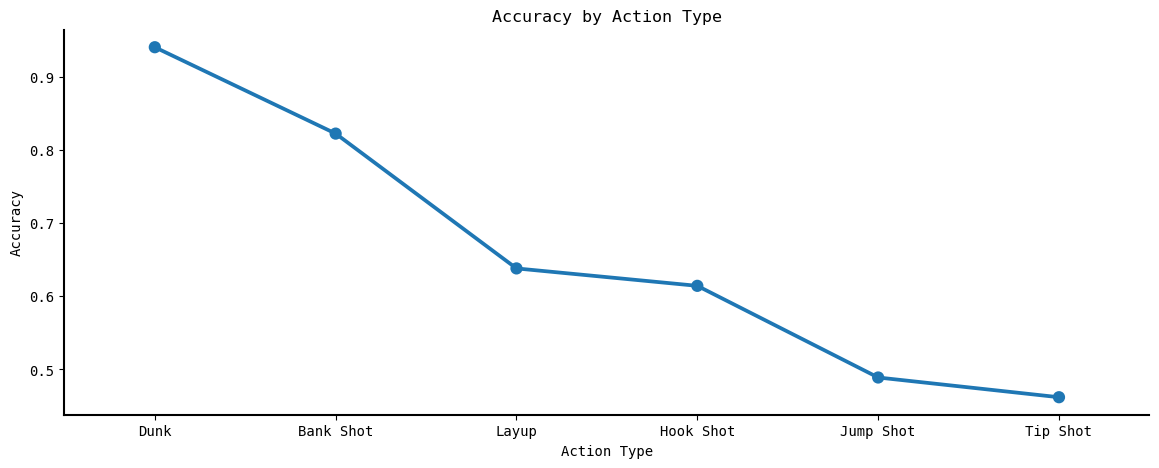

In [411]:
accuracy = train.groupby("combined_shot_type")[['shot_made_flag']].mean().sort_values(by='shot_made_flag',ascending=False).reset_index()

sns.pointplot(x='combined_shot_type', y='shot_made_flag', data=accuracy)
plt.title('Accuracy by Action Type')
plt.ylabel('Accuracy')
plt.xlabel('Action Type')
sns.despine()

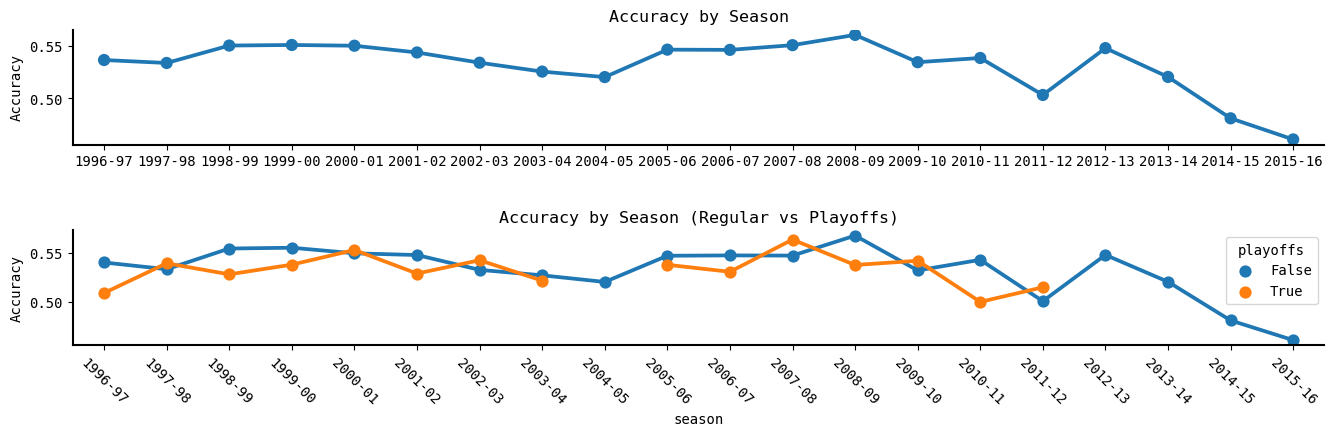

In [412]:
fig, axs= plt.subplots(nrows=2)

accuracy = train.groupby("season")[['shot_made_flag']].mean().reset_index()

sns.pointplot(x='season', y='shot_made_flag', data=accuracy, ax=axs[0])
axs[0].set_title("Accuracy by Season")
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('')
# axs[0].set_xticks(rotation=-45)
sns.despine()

p = train.groupby(["season", "playoffs"])[['shot_made_flag']].mean().reset_index()

sns.pointplot(x='season', y='shot_made_flag', data=p, hue='playoffs', ax=axs[1])
plt.title("Accuracy by Season (Regular vs Playoffs)")
plt.ylabel('Accuracy')
plt.xticks(rotation=-45)


fig.tight_layout(pad=3.0)

sns.despine()

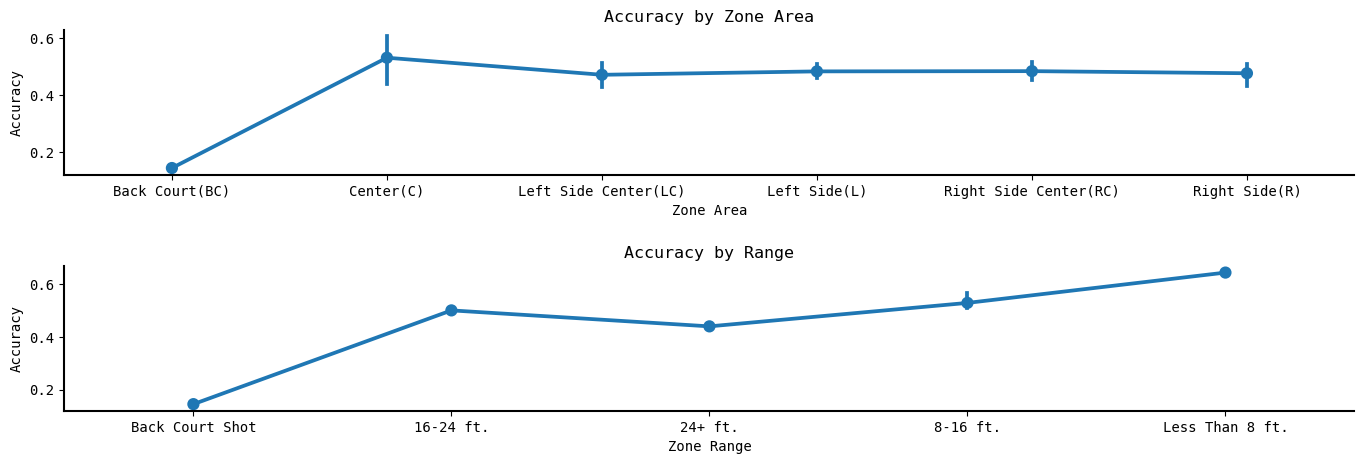

In [413]:
q = train.groupby(['shot_zone_area','shot_zone_range'])[['shot_made_flag']].mean().reset_index()

fig, axs= plt.subplots(nrows=2)

sns.pointplot(x='shot_zone_area', y='shot_made_flag', data=q, ax=axs[0])
axs[0].set_title("Accuracy by Zone Area")
axs[0].set_ylabel('Accuracy')
axs[0].set_xlabel('Zone Area')

sns.pointplot(x='shot_zone_range', y='shot_made_flag', data=q, ax=axs[1])
plt.title("Accuracy by Range")
plt.ylabel('Accuracy')
plt.xlabel('Zone Range')

sns.despine()
fig.tight_layout(pad=2.0)

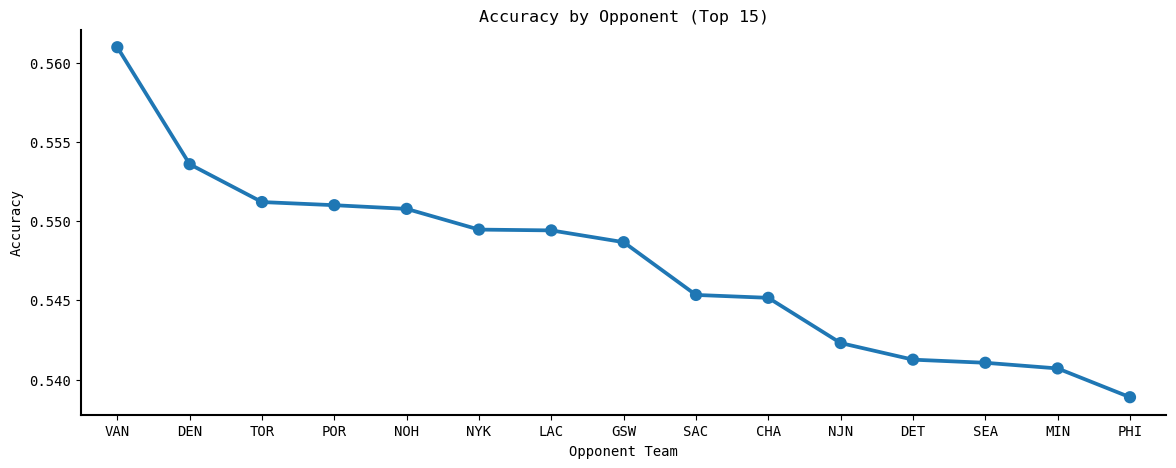

In [414]:
o = train.groupby("opponent")[['shot_made_flag']].mean().sort_values(by='shot_made_flag', ascending=False)[:15].reset_index()

sns.pointplot(x='opponent', y='shot_made_flag', data=o)
plt.title("Accuracy by Opponent (Top 15)")
plt.ylabel('Accuracy')
plt.xlabel('Opponent Team')

sns.despine()

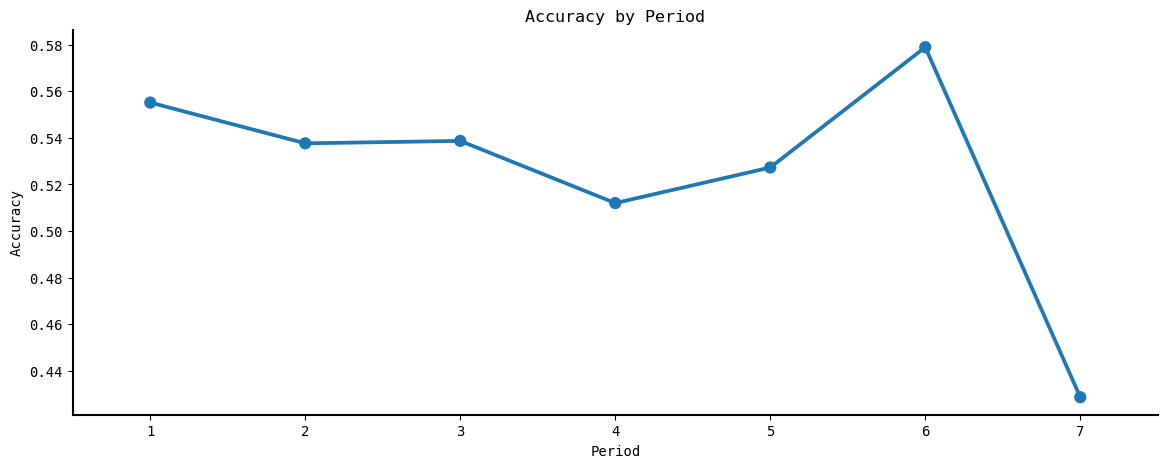

In [415]:
p = train.groupby("period")[['shot_made_flag']].mean().sort_values(by='shot_made_flag', ascending=False).reset_index()

ax = sns.pointplot(x='period', y='shot_made_flag', data=p)
plt.title("Accuracy by Period")
plt.ylabel("Accuracy")
plt.xlabel("Period")
sns.despine()

Edited from https://www.kaggle.com/code/selfishgene/psychology-of-a-professional-athlete

In [416]:
def seconds_from_period_start(df):
    if df.period <=4:
        return 60*(12-df['minutes_remaining'])+(60-df['seconds_remaining'])
    else:
        return 60*(5-df['minutes_remaining'])+(60-df['seconds_remaining'])

In [417]:
train['seconds_from_period_start'] = train.apply(seconds_from_period_start, axis=1)

In [418]:
def total_sec(df):
    return df.minutes_remaining*60 + df.seconds_remaining

train["total_sec_remaining"] = train.apply(total_sec, axis=1)

In [419]:
train.loc[:5, ['period','minutes_remaining', 'seconds_remaining', 'seconds_from_period_start', "total_sec_remaining"]]

,period,minutes_remaining,seconds_remaining,seconds_from_period_start,total_sec_remaining
0,1,10,27,153,627
1,1,10,22,158,622
2,1,7,45,315,465
3,1,6,52,368,412
4,2,6,19,401,379
5,3,9,32,208,572


In [420]:
train["under_5_sec"] = train.seconds_remaining.apply(lambda x:1 if x<=5 else 0).astype(np.bool_)

Copied from https://www.kaggle.com/code/aakashkerawat/exploring-and-predicting-lb-score-0-60160/notebook

In [421]:
#The angle from which the shot was made.
train['angle'] = train.apply(lambda row: 90 if row['loc_y']==0 else math.degrees(math.atan(row['loc_x']/abs(row['loc_y']))),axis=1)
train['angle'] = np.round(train.angle, 2)

In [422]:
#Binning the angle, optimum size selected by cross validation.
train['angle_bin'] = pd.cut(train.angle, 7, labels=range(7))
train['angle_bin'] = train.angle_bin.astype("uint8")

In [423]:
train.loc[train['action_type']== 'Running Slam Dunk Shot', 'action_type'] = 'Slam Dunk Shot'
train.loc[train['action_type']== 'Driving Floating Bank Jump Shot', 'action_type'] = 'Jump Bank Shot'

In [424]:
train['action_type'] = train.action_type.str.lower()
train['action_type'] = train.action_type.str.replace("shot", '')

In [425]:
train['combined_shot_type'] = train.combined_shot_type.str.replace("Shot", '')
train['combined_shot_type'] = train.combined_shot_type.str.lower()

In [426]:
train['away'] = train.matchup.str.contains('@')

In [427]:
def num_actions(x):
    words = x.split()
    return len(words)

train['num_actions'] = train.action_type.apply(num_actions)

In [428]:
train["sqrt_lat_lon"] = np.sqrt(np.absolute(train['loc_x'])*np.absolute(train['loc_y'])).astype("float16")

In [429]:
train.drop(columns=["game_date", "alpha", "loc_x", "loc_y", "matchup", "playoffs", "seconds_remaining", "minutes_remaining"], axis=1, inplace=True, errors="ignore")

In [430]:
train.corrwith(train['shot_made_flag'])

lat                          0.125653
lon                         -0.001027
period                      -0.027885
shot_distance               -0.167631
shot_made_flag               1.000000
shot_type                   -0.104488
seconds_from_period_start   -0.025305
total_sec_remaining          0.025622
under_5_sec                 -0.038521
angle                        0.085107
angle_bin                    0.078542
away                        -0.019346
num_actions                  0.279485
sqrt_lat_lon                -0.137524
dtype: float64

## ML Step

In [1]:
from sklearn.preprocessing import PowerTransformer, OneHotEncoder, LabelEncoder
from sklearn.metrics import log_loss
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import log_loss
from sklearn.ensemble import AdaBoostClassifier, ExtraTreesClassifier, RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression # 0.60 
from sklearn.feature_selection import SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

In [432]:
X = train.drop(columns=["shot_made_flag"])
y = train.shot_made_flag

In [433]:
print(X.shape, y.shape)

(30697, 20) (30697,)


In [112]:
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.33, random_state=42)

In [113]:
# print(X_train.shape, y_train.shape)

(20566, 21) (20566,)


In [434]:
num_cols = [col for col in X.columns if X[col].dtype!='O' ]
cat_cols = [col for col in X.columns if X[col].dtype=='O']

In [436]:
num_pipe = make_pipeline(PowerTransformer())                     
cat_pipe = make_pipeline(OneHotEncoder(sparse=False, handle_unknown="ignore"))

col_transformer = make_column_transformer(
                                        (num_pipe, num_cols),
                                        (cat_pipe, cat_cols))  

In [437]:
def model_fit(pipe, param_grid):
    C = np.random.exponential(scale=.2, size=10)
    
    grid = GridSearchCV(f_pipe, 
                        param_grid=param_grid, 
                        n_jobs=-1, 
                        scoring='neg_log_loss', 
                        error_score="raise", 
                        cv=3)

    grid.fit(X, y)

    print("Best Params:", grid.best_params_)
    print("Best Score:", np.abs(grid.best_score_))

# Logistic Regression

In [438]:
clf = LogisticRegression(n_jobs=-1, fit_intercept=False, random_state=0)
f_pipe = make_pipeline(col_transformer, clf)

C = np.linspace(.01, 1, 15)
param_grid = {"logisticregression__C": C}

model_fit(f_pipe, param_grid=param_grid)

# Best Params: {'logisticregression__C': 0.29285714285714287}
# Best Score: 0.6363659227685093

Best Params: {'logisticregression__C': 0.01}
Best Score: 0.638998860078877


# SelectFromModel

In [34]:
# sm = SelectFromModel(estimator=f_pipe, threshold="1.25*mean", importance_getter="named_steps.logisticregression.coef_")
# sm.fit(X_train, y_train)

# # =========================================
# C = np.random.exponential(scale=.2, size=10)
# param_grid = {"logisticregression__C": C}

# model_fit(f_pipe, param_grid=param_grid)

# Best Params: {'logisticregression__C': 0.2280788376007469}
# Best Score: 0.6378161289229591

# CalibratedClassifier & LinearSVC

In [ ]:
# lin_svc = LinearSVC(fit_intercept=False, random_state=0, dual=False)

# clf = CalibratedClassifierCV(lin_svc, n_jobs=-1)

# param_grid = {"calibratedclassifiercv__base_estimator__C": C}

# model_fit(f_pipe, param_grid=param_grid)

# AdaBoostClassifier

In [183]:
# clf = AdaBoostClassifier(random_state=0)

# param_grid = {"adaboostclassifier__n_estimators": np.arange(50, 100, 10), 
#              "adaboostclassifier__learning_rate": np.linspace(.01,1, 5)}

# model_fit(pipe=f_pipe, param_grid=param_grid)

# # Best Params: {'adaboostclassifier__learning_rate': 0.01, 
# #               'adaboostclassifier__n_estimators': 50}
    
# # Best Score: 0.6295991585476245

Best Params: {'adaboostclassifier__learning_rate': 0.01, 'adaboostclassifier__n_estimators': 50}
Best Score: 0.6493247700245881


# ExtraTreesClassifier

In [ ]:
# clf = ExtraTreesClassifier(n_jobs=-1, random_state=0)
# f_pipe = make_pipeline(col_transformer, clf)

# param_grid = {"extratreesclassifier__n_estimators": np.arange(100, 500, 10), 
#              "extratreesclassifier__max_depth": np.arange(4,10,2), 
#              "extratreesclassifier__min_samples_leaf": np.arange(0.2, 1, 5)}

# model_fit(pipe=f_pipe, param_grid=param_grid)

# Best Params: {'extratreesclassifier__max_depth': 4, 
#               'extratreesclassifier__min_samples_leaf': 0.2, 
#               'extratreesclassifier__n_estimators': 100}
    
# Best Score: 0.6543444333312357

# RandomForestClassifier

In [ ]:
# clf = RandomForestClassifier(n_jobs=-1, random_state=0)
# f_pipe = make_pipeline(col_transformer, clf)

# param_grid = {"randomforestclassifier__n_estimators": np.arange(100, 500, 10), 
#              "randomforestclassifier__max_depth": np.arange(4,10,2), 
#              "randomforestclassifier__min_samples_leaf": np.arange(0.2, 1, 5),
#              "randomforestclassifier__max_samples": np.arange(0.2, 1, 5), 
#              "randomforestclassifier__max_leaf_nodes":np.arange(4,10,2)}

# model_fit(pipe=f_pipe, param_grid=param_grid)

# HistGradientBoostingClassifier

In [ ]:
# clf = HistGradientBoostingClassifier(max_iter=400,
#                                      random_state=0, 
#                                      warm_start=True, 
#                                      scoring='neg_log_loss', 
#                                      validation_fraction=None)

# f_pipe = make_pipeline(col_transformer, clf)

# param_grid = {"histgradientboostingclassifier__max_depth": np.arange(4,10,2)}

# model_fit(pipe=f_pipe, param_grid=param_grid)

# Best Params: {'histgradientboostingclassifier__max_depth': 4}
# Best Score: 0.6137643304916025

In [35]:
import xgboost as xgb

In [80]:
param_grid = {"xgbclassifier__n_estimators":np.arange(300, 600, 1000), 
            "xgbclassifier__max_depth":np.arange(4, 10), 
            "xgbclassifier__colsample_bytree":np.linspace(.6, 1, 3), 
            "xgbclassifier__colsample_bylevel":np.linspace(.6, 1, 3),
            "xgbclassifier__learning_rate":np.linspace(.01, .3, 5)}

num=1
for v in param_grid.values():
    num*=len(v)
print(num, "Different Combinations to Try.")

270 Different Combinations to Try.


In [82]:
clf = xgb.XGBClassifier(
                        objective="binary:logistic", 
                        booster="gbtree", 
                        n_jobs=-1, 
                        eval_metric='logloss', 
                        num_parallel_tree=3, 
                        use_label_encoder=False, 
                        predictor="gpu_predictor", 
                        tree_method="gpu_hist", 
                        validate_parameters=True, 
                        random_state=0)


f_pipe = make_pipeline(col_transformer, clf)

# model_fit(pipe=f_pipe, param_grid=param_grid)

# Best Params: {'xgbclassifier__colsample_bylevel': 0.6, 
#               'xgbclassifier__colsample_bytree': 0.6, 
#               'xgbclassifier__learning_rate': 0.01, 
#               'xgbclassifier__max_depth': 6, 
#               'xgbclassifier__n_estimators': 300}
    
# Best Score: 0.6326225166888007

In [439]:
test = pd.read_csv("train.csv")
test = test[test["shot_made_flag"].isna()]

In [440]:
test['seconds_from_period_start'] = test.apply(seconds_from_period_start, axis=1)

In [441]:
test['seconds_from_game_start'] = test.apply(seconds_from_game_start, axis=1)

In [442]:
test["sqrt_lat_lon"] = np.sqrt(np.absolute(test['loc_x'])*np.absolute(test['loc_y']))
test['away'] = test.matchup.str.contains('@')
test['combined_shot_type'] = test.combined_shot_type.str.replace("Shot", '')
test['combined_shot_type'] = test.combined_shot_type.str.lower()
test['action_type'] = test.action_type.str.lower()
test['action_type'] = test.action_type.str.replace("shot", '')

test.loc[test['action_type']== 'Running Slam Dunk Shot', 'action_type'] = 'Slam Dunk Shot'
test.loc[test['action_type']== 'Driving Floating Bank Jump Shot', 'action_type'] = 'Jump Bank Shot'

#The angle from which the shot was made.
test['angle'] = test.apply(lambda row: 90 if row['loc_y']==0 else math.degrees(math.atan(row['loc_x']/abs(row['loc_y']))),axis=1)
test['angle'] = np.round(test.angle, 2)

#Binning the angle, optimum size selected by cross validation.
test['angle_bin'] = pd.cut(test.angle, 7, labels=range(7))
test['angle_bin'] = test.angle_bin.astype("uint8")

test['seconds_from_game_start'] = train.apply(seconds_from_game_start, axis=1)

test.shot_type.replace(['2PT Field Goal', '3PT Field Goal'], [0,1], inplace=True)


In [443]:
test['num_actions'] = test.action_type.apply(num_actions)

In [444]:
test["under_5_sec"] = test.seconds_remaining.apply(lambda x:1 if x<=5 else 0).astype(np.bool_)
test["total_sec_remaining"] = test.apply(total_sec, axis=1)

In [451]:
test.drop(columns=["game_date", "alpha", "loc_x", "loc_y", "matchup", "playoffs", "seconds_remaining", "minutes_remaining", "seconds_from_game_start"], axis=1, inplace=True, errors="ignore")

In [453]:
clf = LogisticRegression(n_jobs=-1, fit_intercept=False, random_state=0, C=.01)
f_pipe = make_pipeline(col_transformer, clf)
f_pipe.fit(X, y)

preds=f_pipe.predict_proba(test)

In [454]:
preds_df=pd.DataFrame({'shot_made_flag':preds[:,1]},index=df[df.shot_made_flag.isnull()].index+1)
preds_df.index.name='shot_id'
preds_df.to_csv('submission.csv')